### Image Search Exploration

This notebook demonstrates how to configure a MongoDB collection to store vector embeddings.
It then shows how to load images from disk and to use the [clip-ViT-L-14](https://huggingface.co/sentence-transformers/clip-ViT-L-14) multi-modal transformer to create embeddings for each image.

Finally, it demonstrates how to generate a vector embedding from a text phrase, using the same transformer, and to use that to look up appropriate images in the MongoDB collection.

In order to run this notebook, you'll need to set the `MONGODB_URI` environment variable to a connection string for a MongoDB cluster running MongoDB 7.0.2 or above.

In [ ]:
# Uncomment the next line to install all the requirements:
!pip install -r requirements.txt

In [3]:
from glob import glob
from math import ceil
import os
from pathlib import Path
from random import choices
import re

import cv2
import matplotlib.pyplot as plt
from PIL import Image

# I'm using MongoDB as my vector database:
from pymongo import MongoClient
from pymongo.errors import CollectionInvalid, DuplicateKeyError
from pymongo.operations import SearchIndexModel

from sentence_transformers import SentenceTransformer # The transformer used to execute the clip model.
from tqdm.notebook import tqdm                        # Nice progress bars

In [15]:
from dotenv import load_dotenv
load_dotenv()  # Load the .env file
# These can be modified if they're not appropriate for your cluster:
DATABASE_NAME = "image_search_demo"
IMAGE_COLLECTION_NAME = "images"

# Change this to 1000 to load a suitable number of images into MongoDB:
NUMBER_OF_IMAGES_TO_LOAD = 10

# Set this as an environment variable to avoid accidentally sharing your cluster credentials:
MONGODB_URI = os.environ["MONGODB_URI"]

## Configure the MongoDB Collection

First, connect to the MongoDB cluster, and configure the collection so that the "embedding" field has an appropriate vector search index.

* [How to index your vector embeddings](https://www.mongodb.com/docs/atlas/atlas-search/field-types/knn-vector/)

In [35]:
client = MongoClient(MONGODB_URI)
db = client.get_database(DATABASE_NAME)

# Ensure the collection exists, because otherwise you can't add a search index to it.
try:
    db.create_collection(IMAGE_COLLECTION_NAME)
except CollectionInvalid:
    # This is raised when the collection already exists.
    print("Images collection already exists")

# Add a search index (if it doesn't already exist):
collection = db.get_collection(IMAGE_COLLECTION_NAME)
if len(list(collection.list_search_indexes(name="default"))) == 0:
    print("Creating search index...")
    collection.create_search_index(
        SearchIndexModel(
            {
                "mappings": {
                    "dynamic": True,
                    "fields": {
                        "embedding": {
                            "dimensions": 768,
                            "similarity": "cosine",
                            "type": "knnVector",
                        }
                    },
                }
            },
            name="default",
        )
    )
    print("Done.")
else:
    print("Vector search index already exists")

Images collection already exists
Creating search index...
Done.


## Load Images Into the Collection

The following section configures the "clip-ViT-L-14" sentence transformer, and then uses it to create embedding vectors for a number of sample images before loading the file path and vector data into MongoDB.

I have a subdirectory called 'images' that contains all my images (in sub-folders). I downloaded my images from [Kaggle's ImageNet 1000 (mini) dataset](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

In [29]:
# Load CLIP model.
# This may print out warnings, which can be ignored.
model = SentenceTransformer("clip-ViT-L-14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [39]:
def load_images(image_count=1000):
    """
    Load `image_count` images into the database, creating an embedding for each using the sentence transformer above.

    This can take some time to run if image_count is large.

    The image's pixel data is not loaded into MongoDB, just the image's path and vector embedding.
    """
    result = glob("images/*.jpeg", recursive=True)
    # print('result=', result)
    # raise Exception("Sorry, my bad")
    image_paths = choices(result, k=image_count)
    print('image_paths=', image_paths)
    for path in tqdm(image_paths):
        emb = model.encode(Image.open(path))
        try:
            doc = collection.insert_one(
                {
                    "_id": re.sub("images/", "", path),
                    "embedding": emb.tolist(),
                }
            )
        except DuplicateKeyError:
            pass

load_images(NUMBER_OF_IMAGES_TO_LOAD)

image_paths= ['images/n01443537_10408.jpeg', 'images/n01443537_10408.jpeg', 'images/n01443537_10408.jpeg', 'images/n01443537_10092.jpeg', 'images/n01443537_10408.jpeg', 'images/n01443537_10408.jpeg', 'images/n01443537_10408.jpeg', 'images/n01443537_10092.jpeg', 'images/n01443537_18160.jpeg', 'images/n01443537_18160.jpeg']


  0%|          | 0/10 [00:00<?, ?it/s]

## Query the Images in MongoDB

This section defines a function to display images in the notebook, and another function to search MongoDB using user-defined phrases.

There are then some demonstrations of the kinds of results that are returned when using MongoDB's Vector Search feature.

In [40]:
def display_images(docs, cols=1, show_paths=False):
    """
    Helper function to display some images in a grid.
    """
    for doc in docs:
        doc["image_path"] = "images/" + doc["_id"]

    # rows = ceil(len(docs) / cols)
    rows=1

    
    for i, doc in enumerate(docs):
        f, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8), tight_layout=True)
        print('doc=', i, doc)
        image_path = doc["image_path"]
        score = doc["score"]
        image = cv2.imread(image_path)[:, :, ::-1]
        # print('aaaa', i // cols, i % cols)
        # print('bbbb', axarr)
        # axis = axarr[i // cols, i % cols]
        axis = axarr
        axis.imshow(image)
        axis.axis("off")
        if show_paths:
            axis.set_title(image_path.rsplit("/", 1)[1])
        else:
            axis.set_title(f"Score: {score:.4f}")
        plt.show()


def image_search(search_phrase):
    """
    Use MongoDB Vector Search to search for a matching image.

    The `search_phrase` is first converted to a vector embedding using
    the `model` loaded earlier in the Jupyter notebook. The vector is then used
    to search MongoDB for matching images.
    """
    emb = model.encode(search_phrase)
    
    raw_query_aggregate = [
            {
                "$vectorSearch": {
                    "index": "default",
                    "path": "embedding",
                    "queryVector": emb.tolist(),
                    "numCandidates": 100,
                    "limit": 9,
                }
            },
            {"$project": {"_id": 1, "score": {"$meta": "vectorSearchScore"}}},
        ]
    cursor = collection.aggregate(raw_query_aggregate)
    
    print('raw_query_aggregate', raw_query_aggregate)

    return list(cursor)

raw_query_aggregate [{'$vectorSearch': {'index': 'default', 'path': 'embedding', 'queryVector': [-0.6621323823928833, 0.350708931684494, 0.04059460759162903, -0.4626387655735016, -0.16522493958473206, 0.14391720294952393, 0.25633734464645386, -0.19902083277702332, -0.5519498586654663, 0.20671799778938293, 0.0711631178855896, -0.41631847620010376, 0.2619814872741699, -0.04365891218185425, 0.56267249584198, 0.0665183812379837, -0.5844237208366394, 0.2961355149745941, -0.05149412155151367, -0.2744152545928955, -0.19938848912715912, 0.589232861995697, 0.34046733379364014, 0.16589945554733276, 0.31487876176834106, -0.4952656328678131, -0.26572757959365845, -0.3057047724723816, 0.38565903902053833, -0.27716773748397827, -0.09716422110795975, 0.005163058638572693, 0.014636501669883728, 0.03300439566373825, 0.6828650236129761, 0.11179740726947784, -0.2375515252351761, -0.17193235456943512, 0.13403329253196716, -0.7181903719902039, -0.3253120183944702, -0.1947258710861206, 0.3211781978607178, 0

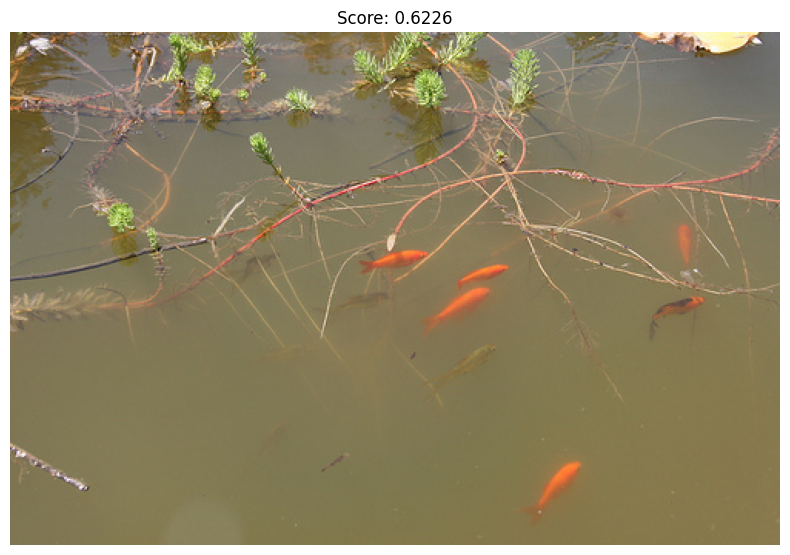

doc= 1 {'_id': 'n01443537_18160.jpeg', 'score': 0.6203734874725342, 'image_path': 'images/n01443537_18160.jpeg'}


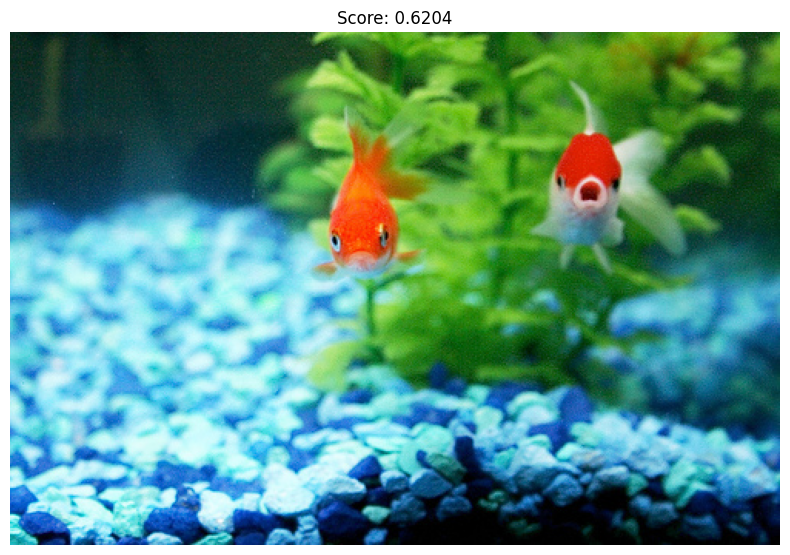

doc= 2 {'_id': 'n01443537_10408.jpeg', 'score': 0.613068699836731, 'image_path': 'images/n01443537_10408.jpeg'}


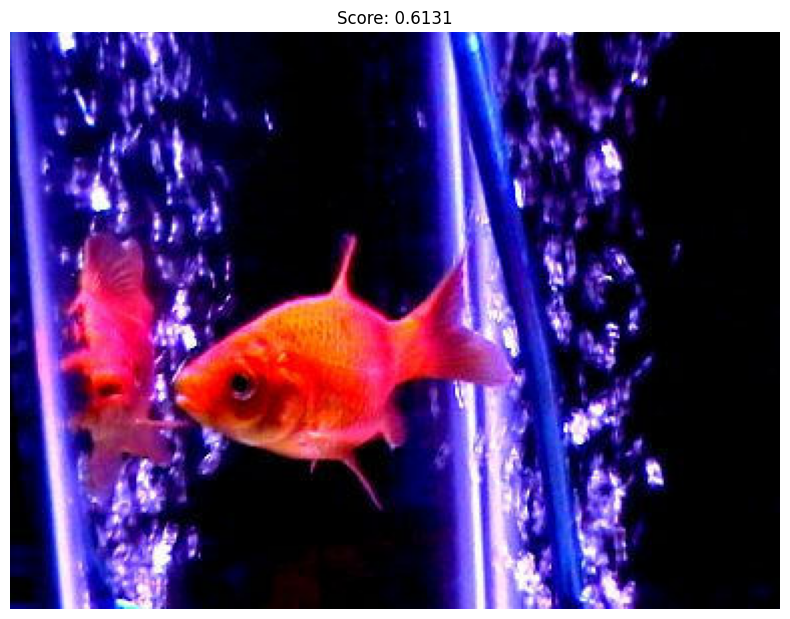

In [41]:
display_images(image_search("there fishes in water and green background"))

emb= [-0.6118037700653076, -0.22435162961483002, 0.030120372772216797, -0.10306870937347412, -0.3705444931983948, 0.37064650654792786, 0.2120857536792755, -0.4071228504180908, -0.5827843546867371, 0.4760245680809021, 0.38846513628959656, -0.24635744094848633, -0.21651975810527802, 0.10294143855571747, -0.0917728990316391, 0.11876669526100159, -0.35847216844558716, 0.07735335826873779, -0.23843373358249664, -0.32355964183807373, 0.13738538324832916, 0.5462149381637573, 0.2830030024051666, -0.1437862515449524, -0.1804051548242569, -0.29109060764312744, 0.12061309814453125, -0.4283198118209839, -0.253641277551651, 0.42343372106552124, 0.16183026134967804, 0.5052383542060852, -0.4872758984565735, 0.31655019521713257, 0.46405476331710815, 0.13303306698799133, -0.008643543347716331, 0.23231282830238342, 0.6188516020774841, -0.13415002822875977, -0.1771499514579773, -0.6990302205085754, 0.44000107049942017, 0.15012729167938232, 0.18161895871162415, -0.06376111507415771, -0.10457247495651245, 

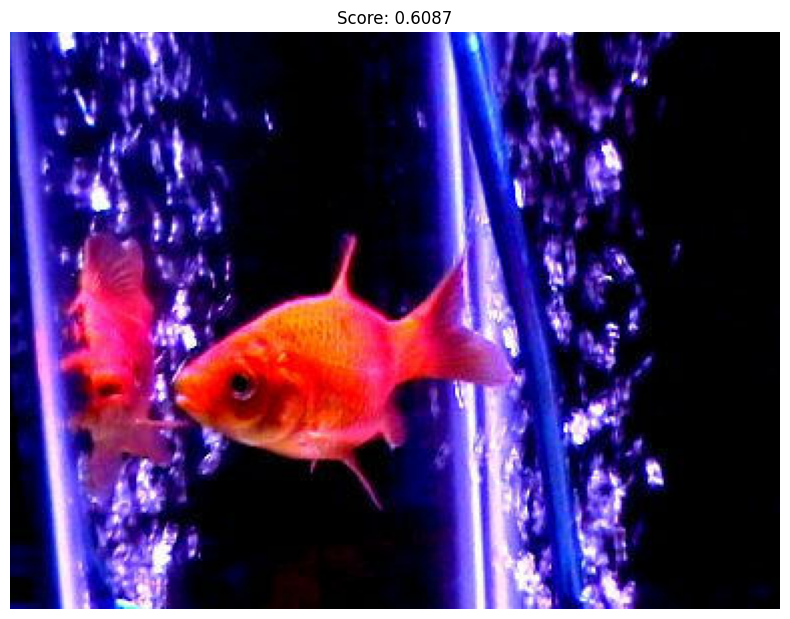

doc= 1 {'_id': 'n01443537_10092.jpeg', 'score': 0.6070290803909302, 'image_path': 'images/n01443537_10092.jpeg'}
image_path2= Axes(0.125,0.11;0.775x0.77)


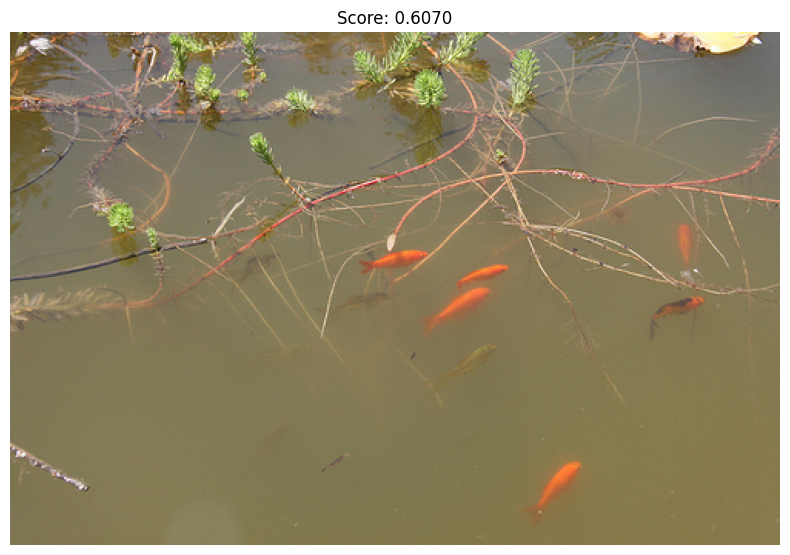

In [21]:
display_images(image_search("big fish in water"))